<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle
import os
import platform
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
dataset_folder = './3_archive'
zip_file = '3_archive.zip'

if not os.path.exists(dataset_folder):
    if not os.path.exists(zip_file):
        if platform.system() == 'Windows':
            !curl -LJO https://raw.githubusercontent.com/Oks11111/NLP_TP/main/3_archive.zip
        else:
            !wget https://raw.githubusercontent.com/Oks11111/NLP_TP/main/3_archive.zip
    if os.path.exists(zip_file):
        !unzip -q 3_archive.zip
    else:
        print("Error: Failed to download the dataset zip file.")
else:
    print("El dataset ya se encuentra descargado")

--2023-06-15 20:21:47--  https://raw.githubusercontent.com/Oks11111/NLP_TP/main/3_archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 737172 (720K) [application/zip]
Saving to: ‘3_archive.zip’

3_archive.zip       100%[===================>] 719.89K  --.-KB/s    in 0.05s   

2023-06-15 20:21:48 (15.5 MB/s) - ‘3_archive.zip’ saved [737172/737172]



In [3]:
! ls

3_archive.zip			MindenSep12_2020.txt
BattleCreekDec19_2019.txt	MinneapolisOct10_2019.txt
BemidjiSep18_2020.txt		MosineeSep17_2020.txt
CharlestonFeb28_2020.txt	NewHampshireAug15_2019.txt
CharlotteMar2_2020.txt		NewHampshireAug28_2020.txt
CincinnatiAug1_2019.txt		NewHampshireFeb10_2020.txt
ColoradorSpringsFeb20_2020.txt	NewMexicoSep16_2019.txt
DallasOct17_2019.txt		OhioSep21_2020.txt
DesMoinesJan30_2020.txt		PhoenixFeb19_2020.txt
FayettevilleSep19_2020.txt	PittsburghSep22_2020.txt
FayettevilleSep9_2019.txt	sample_data
FreelandSep10_2020.txt		TexasSep23_2019.txt
GreenvilleJul17_2019.txt	ToledoJan9_2020.txt
HendersonSep13_2020.txt		TulsaJun20_2020.txt
HersheyDec10_2019.txt		TupeloNov1_2019.txt
LasVegasFeb21_2020.txt		WildwoodJan28_2020.txt
LatrobeSep3_2020.txt		Winston-SalemSep8_2020.txt
LexingtonNov4_2019.txt		YumaAug18_2020.txt
MilwaukeeJan14_2020.txt


In [4]:
# Posibles bandas
os.listdir("./")

['.config',
 'TupeloNov1_2019.txt',
 'CharlotteMar2_2020.txt',
 'MinneapolisOct10_2019.txt',
 'OhioSep21_2020.txt',
 'PhoenixFeb19_2020.txt',
 'LatrobeSep3_2020.txt',
 'WildwoodJan28_2020.txt',
 'GreenvilleJul17_2019.txt',
 'MindenSep12_2020.txt',
 'PittsburghSep22_2020.txt',
 'MosineeSep17_2020.txt',
 'TexasSep23_2019.txt',
 'NewHampshireAug28_2020.txt',
 'FreelandSep10_2020.txt',
 'DallasOct17_2019.txt',
 'YumaAug18_2020.txt',
 'HendersonSep13_2020.txt',
 'NewHampshireFeb10_2020.txt',
 'HersheyDec10_2019.txt',
 'NewMexicoSep16_2019.txt',
 'CincinnatiAug1_2019.txt',
 'ToledoJan9_2020.txt',
 'Winston-SalemSep8_2020.txt',
 'DesMoinesJan30_2020.txt',
 'NewHampshireAug15_2019.txt',
 'MilwaukeeJan14_2020.txt',
 'ColoradorSpringsFeb20_2020.txt',
 'BattleCreekDec19_2019.txt',
 'FayettevilleSep19_2020.txt',
 'TulsaJun20_2020.txt',
 'LexingtonNov4_2019.txt',
 '3_archive.zip',
 'BemidjiSep18_2020.txt',
 'CharlestonFeb28_2020.txt',
 'FayettevilleSep9_2019.txt',
 'LasVegasFeb21_2020.txt',
 'sampl

In [45]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
import pandas as pd
import glob

# Obtener la lista de archivos .txt en la carpeta actual
archivos_txt = glob.glob('./*.txt')
#archivos_txt= glob.glob('./FayettevilleSep9_2019.txt')

# Crear una variable para almacenar el texto combinado
texto_combinado = ''

# Leer cada archivo .txt y agregar su contenido al texto combinado

count=0
for archivo in archivos_txt:
    count=count+1
    if count>6:
      break
    with open(archivo, 'r') as f:
        contenido = f.read()
        texto_combinado += contenido + '\n'

# Crear el dataframe a partir del texto combinado
df = pd.DataFrame([texto_combinado], columns=['Contenido'])

# Mostrar las primeras filas del dataframe
df.head()


,Contenido
0,"ell, thank you very much. And hello, Tupelo. T..."


In [46]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [47]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [48]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0][0]
text

'ell, thank you very much. And hello, Tupelo. This is great to be with you tonight, the great state of Mississippi. The great state of Mississippi, and by the way, the birthplace of a gentleman, not too many people heard of him, Elvis Presley. But to be with thousands of incredible patriots who put their faith in God, family and country. Right? Four days from now, this state will head to the polls and vote to continue our extraordinary progress with your next governor, Republican Tate Reeves. Great guy. Great guy. Under Republican leadership, jobs are booming, confidence is soaring, wages are rising, crime is falling, and our nation is stronger than ever before. We\'re now an economic powerhouse. We\'ve never been in a position like it. We\'ve rebuilt our military and we have financial strength. And by the way, for those of you with a thing called 401ks, the stock market hit, today, another all-time historic high. Unemployment in Mississippi has reached the lowest rate ever recorded, e

In [49]:
type(text)

str

In [50]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['ell',
 'thank',
 'you',
 'very',
 'much',
 'and',
 'hello',
 'tupelo',
 'this',
 'is',
 'great',
 'to',
 'be',
 'with',
 'you',
 'tonight',
 'the',
 'great',
 'state',
 'of',
 'mississippi',
 'the',
 'great',
 'state',
 'of',
 'mississippi',
 'and',
 'by',
 'the',
 'way',
 'the',
 'birthplace',
 'of',
 'a',
 'gentleman',
 'not',
 'too',
 'many',
 'people',
 'heard',
 'of',
 'him',
 'elvis',
 'presley',
 'but',
 'to',
 'be',
 'with',
 'thousands',
 'of',
 'incredible',
 'patriots',
 'who',
 'put',
 'their',
 'faith',
 'in',
 'god',
 'family',
 'and',
 'country',
 'right',
 'four',
 'days',
 'from',
 'now',
 'this',
 'state',
 'will',
 'head',
 'to',
 'the',
 'polls',
 'and',
 'vote',
 'to',
 'continue',
 'our',
 'extraordinary',
 'progress',
 'with',
 'your',
 'next',
 'governor',
 'republican',
 'tate',
 'reeves',
 'great',
 'guy',
 'great',
 'guy',
 'under',
 'republican',
 'leadership',
 'jobs',
 'are',
 'booming',
 'confidence',
 'is',
 'soaring',
 'wages',
 'are',
 'rising',
 'cr

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [51]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [52]:
# Demos un vistazo
sentence_tokens[:2]

[['ell',
  'thank',
  'you',
  'very',
  'much',
  'and',
  'hello',
  'tupelo',
  'this',
  'is',
  'great',
  'to',
  'be',
  'with',
  'you',
  'tonight',
  'the',
  'great',
  'state',
  'of',
  'mississippi',
  'the',
  'great',
  'state',
  'of',
  'mississippi',
  'and',
  'by',
  'the',
  'way',
  'the',
  'birthplace',
  'of',
  'a',
  'gentleman',
  'not',
  'too',
  'many',
  'people',
  'heard',
  'of',
  'him',
  'elvis',
  'presley',
  'but',
  'to',
  'be',
  'with',
  'thousands',
  'of',
  'incredible',
  'patriots',
  'who',
  'put',
  'their',
  'faith',
  'in',
  'god',
  'family',
  'and',
  'country',
  'right',
  'four',
  'days',
  'from',
  'now',
  'this',
  'state',
  'will',
  'head',
  'to',
  'the',
  'polls',
  'and',
  'vote',
  'to',
  'continue',
  'our',
  'extraordinary',
  'progress',
  'with',
  'your',
  'next',
  'governor',
  'republican',
  'tate',
  'reeves',
  'great',
  'guy',
  'great',
  'guy',
  'under',
  'republican',
  'leadership',
  

In [53]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [54]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['ell', 'thank', 'you', 'very'],
 ['thank', 'you', 'very', 'much'],
 ['you', 'very', 'much', 'and'],
 ['very', 'much', 'and', 'hello'],
 ['much', 'and', 'hello', 'tupelo'],
 ['and', 'hello', 'tupelo', 'this'],
 ['hello', 'tupelo', 'this', 'is'],
 ['tupelo', 'this', 'is', 'great'],
 ['this', 'is', 'great', 'to'],
 ['is', 'great', 'to', 'be'],
 ['great', 'to', 'be', 'with'],
 ['to', 'be', 'with', 'you'],
 ['be', 'with', 'you', 'tonight'],
 ['with', 'you', 'tonight', 'the'],
 ['you', 'tonight', 'the', 'great'],
 ['tonight', 'the', 'great', 'state'],
 ['the', 'great', 'state', 'of'],
 ['great', 'state', 'of', 'mississippi'],
 ['state', 'of', 'mississippi', 'the'],
 ['of', 'mississippi', 'the', 'great'],
 ['mississippi', 'the', 'great', 'state'],
 ['the', 'great', 'state', 'of'],
 ['great', 'state', 'of', 'mississippi'],
 ['state', 'of', 'mississippi', 'and'],
 ['of', 'mississippi', 'and', 'by'],
 ['mississippi', 'and', 'by', 'the'],
 ['and', 'by', 'the', 'way'],
 ['by', 'the', 'way', 'the

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [55]:
tok = Tokenizer() 

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [56]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[4279, 72, 6, 45],
 [72, 6, 45, 93],
 [6, 45, 93, 2],
 [45, 93, 2, 1307],
 [93, 2, 1307, 2599],
 [2, 1307, 2599, 19],
 [1307, 2599, 19, 14],
 [2599, 19, 14, 27],
 [19, 14, 27, 3],
 [14, 27, 3, 35],
 [27, 3, 35, 31],
 [3, 35, 31, 6],
 [35, 31, 6, 258],
 [31, 6, 258, 1],
 [6, 258, 1, 27],
 [258, 1, 27, 121],
 [1, 27, 121, 7],
 [27, 121, 7, 305],
 [121, 7, 305, 1],
 [7, 305, 1, 27],
 [305, 1, 27, 121],
 [1, 27, 121, 7],
 [27, 121, 7, 305],
 [121, 7, 305, 2],
 [7, 305, 2, 61],
 [305, 2, 61, 1],
 [2, 61, 1, 87],
 [61, 1, 87, 1],
 [1, 87, 1, 2600],
 [87, 1, 2600, 7],
 [1, 2600, 7, 4],
 [2600, 7, 4, 1535],
 [7, 4, 1535, 46],
 [4, 1535, 46, 153],
 [1535, 46, 153, 133],
 [46, 153, 133, 25],
 [153, 133, 25, 285],
 [133, 25, 285, 7],
 [25, 285, 7, 88],
 [285, 7, 88, 2601],
 [7, 88, 2601, 2602],
 [88, 2601, 2602, 16],
 [2601, 2602, 16, 3],
 [2602, 16, 3, 35],
 [16, 3, 35, 31],
 [3, 35, 31, 306],
 [35, 31, 306, 7],
 [31, 306, 7, 154],
 [306, 7, 154, 683],
 [7, 154, 683, 112],
 [154, 683, 112, 224]

In [57]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

60545


In [58]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

4279


In [59]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'and': 2, 'to': 3, 'a': 4, 'i': 5, 'you': 6, 'of': 7, 'we': 8, 'it': 9, 'they': 10, 'that': 11, 'in': 12, 'have': 13, 'is': 14, 'he': 15, 'but': 16, 'was': 17, "it's": 18, 'this': 19, 'for': 20, 'going': 21, 'our': 22, 'are': 23, 'so': 24, 'people': 25, 'said': 26, 'great': 27, 'know': 28, "don't": 29, 'what': 30, 'with': 31, "we're": 32, 'do': 33, 'right': 34, 'be': 35, 'all': 36, 'on': 37, 'like': 38, 'your': 39, 'no': 40, "that's": 41, "they're": 42, 'want': 43, 'them': 44, 'very': 45, 'not': 46, 'because': 47, 'now': 48, 'will': 49, 'out': 50, 'up': 51, 'one': 52, 'get': 53, 'about': 54, 'if': 55, 'got': 56, 'me': 57, 'had': 58, "he's": 59, 'think': 60, 'by': 61, 'never': 62, 'did': 63, 'from': 64, 'good': 65, 'say': 66, 'years': 67, 'ever': 68, 'just': 69, 'these': 70, 'at': 71, 'thank': 72, 'more': 73, 'doing': 74, 'country': 75, "i'm": 76, 'would': 77, 'been': 78, 'than': 79, 'has': 80, 'president': 81, 'then': 82, 'were': 83, 'as': 84, 'see': 85, 'go': 86, 'way': 87,

In [60]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'very': 839, 'thank': 534, 'you': 4650, 'ell': 1, 'much': 448, 'and': 7249, 'hello': 16, 'tupelo': 4, 'this': 1609, 'is': 1871, 'great': 1322, 'to': 5951, 'be': 1089, 'with': 1243, 'tonight': 136, 'the': 9319, 'state': 336, 'of': 4303, 'mississippi': 107, 'by': 686, 'way': 476, 'birthplace': 4, 'a': 4991, 'gentleman': 12, 'not': 864, 'too': 250, 'many': 282, 'people': 1378, 'heard': 120, 'him': 475, 'elvis': 4, 'presley': 4, 'but': 1828, 'thousands': 100, 'incredible': 249, 'patriots': 40, 'who': 376, 'put': 164, 'their': 321, 'faith': 20, 'in': 3118, 'god': 132, 'family': 108, 'country': 524, 'right': 1121, 'four': 158, 'days': 106, 'from': 636, 'now': 848, 'will': 840, 'head': 40, 'polls': 151, 'vote': 168, 'continue': 28, 'our': 1410, 'extraordinary': 12, 'progress': 24, 'your': 924, 'next': 112, 'governor': 139, 'republican': 151, 'tate': 47, 'reeves': 20, 'guy': 328, 'under': 167, 'leadership': 8, 'jobs': 224, 'are': 1402, 'booming': 12, 'confidence': 1

### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [61]:
# Vistazo a las primeras filas
df.loc[:15]

,Contenido
0,"ell, thank you very much. And hello, Tupelo. T..."


In [62]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'ell, thank you very much. And hello, Tupelo. This is great to be with you tonight, the great state of Mississippi. The great state of Mississippi, and by the way, the birthplace of a gentleman, not too many people heard of him, Elvis Presley. But to be with thousands of incredible patriots who put their faith in God, family and country. Right? Four days from now, this state will head to the polls and vote to continue our extraordinary progress with your next governor, Republican Tate Reeves. Great guy. Great guy. Under Republican leadership, jobs are booming, confidence is soaring, wages are rising, crime is falling, and our nation is stronger than ever before. We\'re now an economic powerhouse. We\'ve never been in a position like it. We\'ve rebuilt our military and we have financial strength. And by the way, for those of you with a thing called 401ks, the stock market hit, today, another all-time historic high. Unemployment in Mississippi has reached the lowest rate ever recorded, e

In [63]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['ell',
 'thank',
 'you',
 'very',
 'much',
 'and',
 'hello',
 'tupelo',
 'this',
 'is',
 'great',
 'to',
 'be',
 'with',
 'you',
 'tonight',
 'the',
 'great',
 'state',
 'of']

In [64]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 60549


In [65]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [66]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['ell', 'thank', 'you', 'very'],
 ['thank', 'you', 'very', 'much'],
 ['you', 'very', 'much', 'and'],
 ['very', 'much', 'and', 'hello'],
 ['much', 'and', 'hello', 'tupelo'],
 ['and', 'hello', 'tupelo', 'this'],
 ['hello', 'tupelo', 'this', 'is'],
 ['tupelo', 'this', 'is', 'great'],
 ['this', 'is', 'great', 'to'],
 ['is', 'great', 'to', 'be'],
 ['great', 'to', 'be', 'with'],
 ['to', 'be', 'with', 'you'],
 ['be', 'with', 'you', 'tonight'],
 ['with', 'you', 'tonight', 'the'],
 ['you', 'tonight', 'the', 'great'],
 ['tonight', 'the', 'great', 'state'],
 ['the', 'great', 'state', 'of'],
 ['great', 'state', 'of', 'mississippi'],
 ['state', 'of', 'mississippi', 'the'],
 ['of', 'mississippi', 'the', 'great']]

In [67]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[4279, 72, 6, 45],
 [72, 6, 45, 93],
 [6, 45, 93, 2],
 [45, 93, 2, 1307],
 [93, 2, 1307, 2599],
 [2, 1307, 2599, 19],
 [1307, 2599, 19, 14],
 [2599, 19, 14, 27],
 [19, 14, 27, 3],
 [14, 27, 3, 35],
 [27, 3, 35, 31],
 [3, 35, 31, 6],
 [35, 31, 6, 258],
 [31, 6, 258, 1],
 [6, 258, 1, 27],
 [258, 1, 27, 121],
 [1, 27, 121, 7],
 [27, 121, 7, 305],
 [121, 7, 305, 1],
 [7, 305, 1, 27]]

In [68]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 60545


### 3 - Input y target

In [69]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [70]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [71]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [72]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(60545, 3)
(60545,)


In [73]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'and',
 3: 'to',
 4: 'a',
 5: 'i',
 6: 'you',
 7: 'of',
 8: 'we',
 9: 'it',
 10: 'they',
 11: 'that',
 12: 'in',
 13: 'have',
 14: 'is',
 15: 'he',
 16: 'but',
 17: 'was',
 18: "it's",
 19: 'this',
 20: 'for',
 21: 'going',
 22: 'our',
 23: 'are',
 24: 'so',
 25: 'people',
 26: 'said',
 27: 'great',
 28: 'know',
 29: "don't",
 30: 'what',
 31: 'with',
 32: "we're",
 33: 'do',
 34: 'right',
 35: 'be',
 36: 'all',
 37: 'on',
 38: 'like',
 39: 'your',
 40: 'no',
 41: "that's",
 42: "they're",
 43: 'want',
 44: 'them',
 45: 'very',
 46: 'not',
 47: 'because',
 48: 'now',
 49: 'will',
 50: 'out',
 51: 'up',
 52: 'one',
 53: 'get',
 54: 'about',
 55: 'if',
 56: 'got',
 57: 'me',
 58: 'had',
 59: "he's",
 60: 'think',
 61: 'by',
 62: 'never',
 63: 'did',
 64: 'from',
 65: 'good',
 66: 'say',
 67: 'years',
 68: 'ever',
 69: 'just',
 70: 'these',
 71: 'at',
 72: 'thank',
 73: 'more',
 74: 'doing',
 75: 'country',
 76: "i'm",
 77: 'would',
 78: 'been',
 79: 'than',
 80: 'has',
 81

In [74]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

4279

In [75]:
y_data_int.shape

(60545,)

In [76]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size+1)

In [77]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [78]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(60545, 4279)

### 4 - Entrenar el modelo

In [79]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [80]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

4279

In [83]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128)) # La última capa LSTM no lleva return_sequences
model.add(Dense(64, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 5)              21400     
                                                                 
 lstm_4 (LSTM)               (None, 3, 128)            68608     
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 4279)              278135    
                                                                 
Total params: 507,983
Trainable params: 507,983
Non-tr

In [84]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
1514/1514 [==============================] - 57s 34ms/step - loss: 6.5054 - accuracy: 0.0390 - val_loss: 6.3900 - val_accuracy: 0.0370
Epoch 2/100
1514/1514 [==============================] - 52s 34ms/step - loss: 6.1597 - accuracy: 0.0473 - val_loss: 6.2606 - val_accuracy: 0.0535
Epoch 3/100
1514/1514 [==============================] - 51s 34ms/step - loss: 5.8559 - accuracy: 0.0660 - val_loss: 6.1679 - val_accuracy: 0.0633
Epoch 4/100
1514/1514 [==============================] - 49s 33ms/step - loss: 5.6275 - accuracy: 0.0791 - val_loss: 6.1465 - val_accuracy: 0.0796
Epoch 5/100
1514/1514 [==============================] - 51s 34ms/step - loss: 5.4348 - accuracy: 0.0933 - val_loss: 6.1692 - val_accuracy: 0.0851
Epoch 6/100
1514/1514 [==============================] - 53s 35ms/step - loss: 5.2666 - accuracy: 0.1042 - val_loss: 6.2036 - val_accuracy: 0.0932
Epoch 7/100
1514/1514 [==============================] - 50s 33ms/step - loss: 5.1177 - accuracy: 0.1135 - val_loss: 6

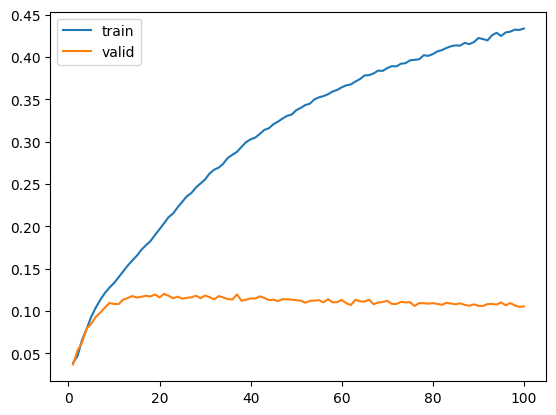

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [86]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [87]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:0

In [88]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-88-2a8fe09160a6>:24: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 26ms/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [91]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [93]:
input_text='state of'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 33ms/step


'state of nuclear five'

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de un severo overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.